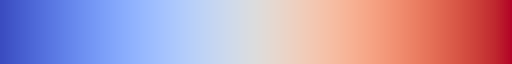

In [87]:
from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
import pathlib

data_bikes = '/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/bikes'
data_trips = '/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/trips/2022'

months_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasons = {
        'Winter': [12, 1, 2],
        'Spring': [3, 4, 5],
        'Summer': [6, 7, 8],
        'Autumn': [9, 10, 11]
    }

zipcode_file = pathlib.Path("/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/tl_2017_us_zcta510.zip")
# Check existence
if zipcode_file.exists():
    zipcode_gdf = gpd.read_file(f"zip://{zipcode_file}")
else:
    print("File not found! Make sure it's in the current directory.")

# set Seaborn style
sns.set_style("whitegrid")
sns.color_palette("coolwarm", as_cmap=True)

In [88]:
def get_date_format(city, year, month):
    year = int(year)
    if city == 'Austin':
        return '%m/%d/%Y %I:%M:%S %p'
    elif city == 'Boston':
        if (year == 2018 and month < 3) or (year == 2023 and month > 2):
            return '%Y-%m-%d %H:%M:%S'
        else:
            return '%Y-%m-%d %H:%M:%S.%f'
    elif city == 'Chicago' or city == 'Columbus' or city == 'Washington':
        return '%Y-%m-%d %H:%M:%S'
    elif city == 'NYC':
        if year <= 2020 or (year == 2021 and month == 0):
            return '%Y-%m-%d %H:%M:%S.%f'
        return '%Y-%m-%d %H:%M:%S'
    elif city == 'Philly':
        if year == 2018 or (year == 2019 and month >= 0 and month <= 5) or (year == 2019 and month >= 9):
            return '%Y-%m-%d %H:%M:%S'
        return '%m/%d/%Y %H:%M'
    elif city == 'SanFrancisco':
        if year < 2020 or (year == 2020 and month < 4):
            return '%Y-%m-%d %H:%M:%S.%f'
        return '%Y-%m-%d %H:%M:%S'

def get_season(month):

    for season, months in seasons.items():
        if month in months:
            return season
    return None

In [89]:
def compare_trip_for_month(path, city):
    '''
    function to plot the number of trips for every month of a specific year

    Inputs:
        - path: path to the folder containing the data
        - city: name of the city

    Outputs:
        - None
    '''

    years = {
        '2018': [0] * 12,
        '2019': [0] * 12,
        '2020': [0] * 12,
        '2021': [0] * 12,
        '2022': [0] * 12,
        '2023': [0] * 12
    }
    
    for year in os.listdir(path):

        year_path = os.path.join(path, year)

        for file in os.listdir(year_path):
            full_path = os.path.join(year_path, file)
            df = pd.read_csv(full_path, dtype=object)

            month = int(file[4:6]) - 1
            years[year][month] = len(df.index)
    
    # plot the number of trips for every month for each year
    for year, months in years.items():
        sns.lineplot(x=months_list, y=months, label=year, marker='o')
    
    # customize the plot axes to show thousands with 'k'
    plt.yticks(np.arange(0, max([max(year) for year in years.values()]) + 1, step=30000), [f'{int(x/1000)}k' for x in np.arange(0, max([max(year) for year in years.values()]) + 1, step=30000)])
    plt.xlabel('Months')
    plt.ylabel('Trips')
    title = 'Number of Trips for every month of ' + city
    plt.title(title)
    plt.show()

In [90]:
def compare_trip_for_hour(year_path, city, year):
    '''
    function to plot the number of trips for every hour of a specific year, month and city
    
    Inputs:
        - year_path: path to the folder containing the data for the specific year
        - city: name of the city
        - year: specific year
    
    Outputs:
        - None
    '''
    
    seasons_result = {
        'Winter': [0] * 24,
        'Spring': [0] * 24,
        'Summer': [0] * 24,
        'Autumn': [0] * 24
    }
    
    print(year_path)
    for file in os.listdir(year_path):
        print(f'Processing file: {file}')
        full_path = os.path.join(year_path, file)
        df = pd.read_csv(full_path, dtype=object)
        
        for index in range(len(df.index)):
            date_format = get_date_format(city, year, file)
            if city == 'SanFrancisco':
                if len(df['stop_time'][index]) == 24:
                    hour = datetime.strptime(df['stop_time'][index], date_format).hour
                else:
                    hour = datetime.strptime(df['stop_time'][index], '%Y-%m-%d %H:%M:%S').hour
            else:
                hour = datetime.strptime(df['stop_time'][index], date_format).hour
            
            # get the correct season
            month = int(file[4:6])
            month = month if month > 9 else int(file[5])
            season = get_season(month)
            
            seasons_result[season][hour] += 1

    return seasons_result

def plot_hours(results, city, year):
    # plot a line plot with seaborn
    
    hours_range = list(range(24))
    for season, hours in results.items():
        hours = [hours[i] for i in list(range(24))]
        sns.lineplot(x=list(range(24)), y=hours, marker='o', label=season)
        # calculate mean
        mean_hours = np.mean(hours)
        print(f'Mean number of trips in {season}: {mean_hours}')
    
    
    plt.legend()
    # customize the plot axes to show thousands with 'k'
    plt.yticks(np.arange(0, max([max(hours) for hours in results.values()]) + 1, step=10000), [f'{int(x/1000)}k' for x in np.arange(0, max([max(hours) for hours in results.values()]) + 1, step=10000)])
    # customize the x-axis to show only the hours in the range 7-9
    plt.xticks(hours_range, [hour for hour in hours_range])
    plt.xlabel('Hours')
    plt.ylabel('Trips')
    title = 'Number of Trips for every hour of ' + city + ' in ' + year
    plt.title(title)        
    plt.show()

In [106]:
def compare_morning_hour(year_path, city, year):
    '''
    function to plot the number of trips for morning hours of a specific year and city
    
    Inputs:
        - year_path: path to the folder containing the data for the specific year
        - city: name of the city
        - year: specific year
    
    Outputs:
        - None
    '''
    
    seasons_result = {
        'Winter': [0] * 180,
        'Spring': [0] * 180,
        'Summer': [0] * 180,
        'Autumn': [0] * 180
    }
    
    print(year_path)
    for file in os.listdir(year_path):
        print(f'Processing file: {file}')
        full_path = os.path.join(year_path, file)
        df = pd.read_csv(full_path, dtype=object)
        
        for index in range(len(df.index)):
            date_format = get_date_format(city, year, file)
            if city == 'SanFrancisco':
                if len(df['stop_time'][index]) == 24:
                    hour = datetime.strptime(df['stop_time'][index], date_format).hour
                    minute = datetime.strptime(df['stop_time'][index], date_format).minute
                else:
                    hour = datetime.strptime(df['stop_time'][index], '%Y-%m-%d %H:%M:%S').hour
                    minute = datetime.strptime(df['stop_time'][index], '%Y-%m-%d %H:%M:%S').minute
            else:
                hour = datetime.strptime(df['stop_time'][index], date_format).hour
                minute = datetime.strptime(df['stop_time'][index], date_format).minute
            
            if hour < 7 or hour > 9:
                continue
            # get the correct season
            month = int(file[4:6])
            month = month if month > 9 else int(file[5])
            season = get_season(month)

            time = hour * 60 + minute - 420
            
            seasons_result[season][time] += 1

    return seasons_result

def plot_morning_hours(results, city, year):
    # plot a line plot with seaborn
    hours_range = list(range(180))

    for season, hours in results.items():
        sns.lineplot(x=hours_range, y=hours, marker='o', label=season)
        # calculate mean
        mean_hours = np.mean(hours)
        print(f'Mean number of trips in {season}: {mean_hours}')
    
    
    plt.legend()
    # customize the plot axes to show thousands with 'k'
    plt.yticks(np.arange(0, max([max(hours) for hours in results.values()]) + 1, step=10000), [f'{int(x/1000)}k' for x in np.arange(0, max([max(hours) for hours in results.values()]) + 1, step=10000)])
    # customize the x-axis to show only the 7:00, 8:00 and 9:00
    plt.xticks([0, 60, 120, 180], ['7:00', '8:00', '9:00', '10:00'])
    plt.xlabel('Hours')
    plt.ylabel('Trips')
    title = 'Number of Trips for every hour of ' + city + ' in ' + year
    plt.title(title)        
    plt.show()

In [92]:
def plot_trips_per_area(path, city, year):
    """
    Function to plot the number of trips per area

    Inputs:
        - path: path to the folder containing the data
        - city: name of the city
        - year: specific year
    """

    city_trips_path = os.path.join(data_trips, city)
    trips_df = pd.read_csv(city_trips_path)

    # group by start_zipcode and count the number of trips
    trips_count = trips_df.groupby('arrival').size().reset_index(name='trip_count')
    # merge with the zipcode geodataframe
    merged_gdf = zipcode_gdf.merge(trips_count, left_on='ZCTA5CE10', right_on='arrival', how='left')
    # fill NaN values with 0
    merged_gdf['trip_count'] = merged_gdf['trip_count'].fillna(0)
    # plot the number of trips per area
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    merged_gdf.plot(column='trip_count', ax=ax, legend=True,
                    legend_kwds={'label': "Number of Trips by Area",
                                 'orientation': "horizontal"},
                    cmap='OrRd', missing_kwds={"color": "lightgrey"})
    

In [100]:
city = 'SanFrancisco'
year = '2022'

city_path = os.path.join(data_bikes, city)
year_path = os.path.join(city_path, year)
hour_results = compare_trip_for_hour(year_path, city, year)
morning_results = compare_morning_hour(year_path, city, year)


/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/bikes/SanFrancisco/2022
Processing file: 202209-baywheels-tripdata.csv
Processing file: 202203-baywheels-tripdata.csv
Processing file: 202204-baywheels-tripdata.csv
Processing file: 202207-baywheels-tripdata.csv
Processing file: 202211-baywheeels-tripdata.csv
Processing file: 202201-baywheels-tripdata.csv
Processing file: 202206-baywheels-tripdata.csv
Processing file: 202205-baywheels-tripdata.csv
Processing file: 202202-baywheels-tripdata.csv
Processing file: 202208-baywheels-tripdata.csv
Processing file: 202210-baywheels-tripdata.csv
Processing file: 202212-baywheels-tripdata.csv
/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/bikes/SanFrancisco/2022
Processing file: 202209-baywheels-tripdata.csv
Processing file: 202203-baywheels-tripdata.csv
Processing file: 202204-baywheels-tripdata.csv
Processing file: 202207-baywheels-tripdata.csv
Processing file: 202211-baywheeels-tripdata.csv
Processing file: 202201-baywheels-tripd

Mean number of trips in Winter: 19201.708333333332
Mean number of trips in Spring: 27341.333333333332
Mean number of trips in Summer: 31858.875
Mean number of trips in Autumn: 30548.083333333332


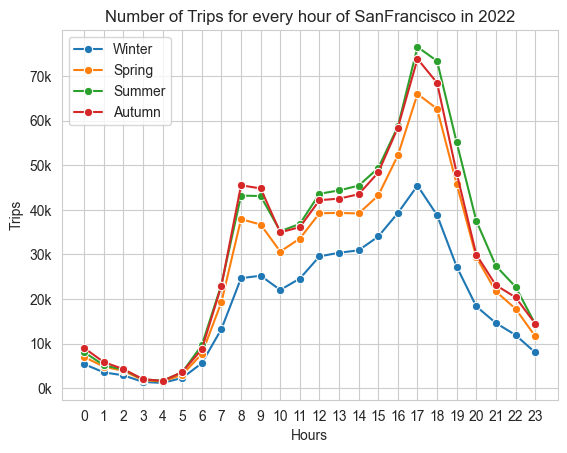

In [101]:
plot_hours(hour_results, city, year)

Mean number of trips in Winter: 351.06666666666666
Mean number of trips in Spring: 521.9
Mean number of trips in Summer: 608.5888888888888
Mean number of trips in Autumn: 629.5722222222222


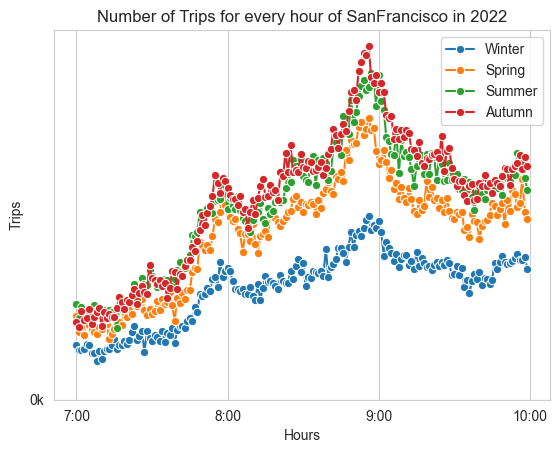

In [107]:
plot_morning_hours(morning_results, city, year)

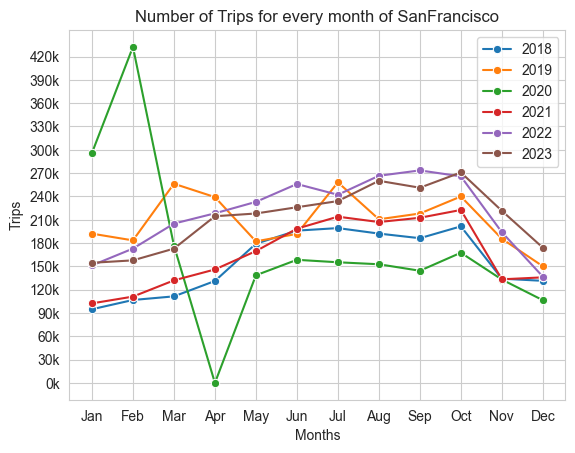

In [95]:
compare_trip_for_month(city_path, city)